# Torus With Varying Fiber Radius

An example of how the `circle_bundles` pipeline can capture topological structure which is not detected with a direct persistence computation.  

We sample from a torus embedded in $\mathbb{R}^{3}$ whose fiber radius continuously oscillates.   

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams

from dreimac import CircularCoords

import circle_bundles as cb

First, generate a noisy sampling:

In [3]:
rng = np.random.default_rng(0)
n_samples = 5000

data, _, true_fiber_angles = cb.sample_R3_torus(
                                    n_samples, 
                                    R = 5,
                                    r_frequency = 5,
                                    r_center = 1,                                     
                                     sigma = 0.1, 
                                     rng = rng, 
                                     return_alpha = True)

Show a visualization of the dataset and compute a persistence diagram from a subsample:

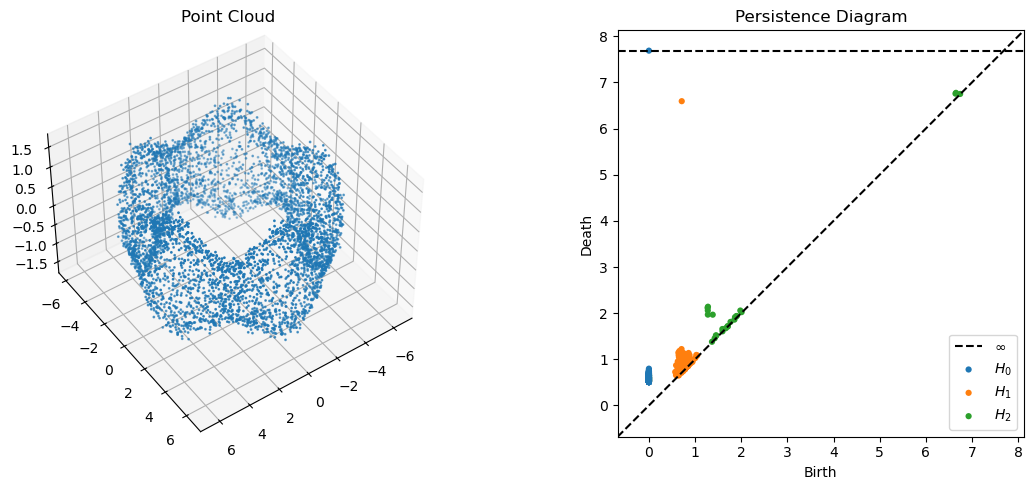

In [14]:
fig = plt.figure(figsize=(12, 5))

# --- Left: 3D point cloud ---
ax3d = fig.add_subplot(1, 2, 1, projection="3d")
ax3d.scatter(data[:, 0], data[:, 1], data[:, 2], s=1)
ax3d.view_init(45, 55)
ax3d.set_title("Point Cloud")

# --- Right: Persistence diagram ---
ax_pd = fig.add_subplot(1, 2, 2)
diagrams = ripser(data, maxdim=2, n_perm=500)["dgms"]
plot_diagrams(diagrams, ax=ax_pd)
ax_pd.set_title("Persistence Diagram")

plt.tight_layout()
plt.show()

Observe that the persistence diagram shows only a single persistence class in dimension 1 (we would expect two for a torus), and we also see no significant class in dimension 2 (we would expect one). This is a result of the large variation in the fiber radius of the underlying model. 

Instead, use a fiberwise approach to detect the global topology. Using the 1-dimensional persistent class representative above as input, invoke the DREiMac library's circular coordinates algorithm {cite}`PereaScoccolaTralie2023DREiMac` to construct a feature map from the dataset to $\mathbb{S}^{1}$:

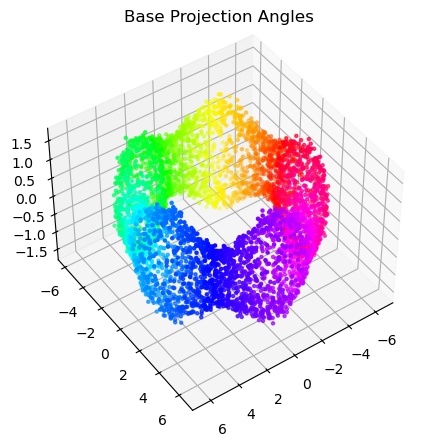

In [4]:
cc = CircularCoords(data, prime = 3, n_landmarks = 500)
base_angles = cc.get_coordinates()

#Show a visualization of the dataset colored by base projection angle
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
sc1 = ax1.scatter(
    data[:, 0], data[:, 1], data[:, 2],
    c=base_angles,
    cmap="hsv",
    s=5,
)
ax1.view_init(45, 55)
ax1.set_title("Base Projection Angles")
plt.show()

Construct a cover of the base space $\mathbb{S}^{1}$ by open balls $\mathcal{U} = \{U_{j}\}_{j=1}^{30}$ around equally-spaced landmarks:

In [5]:
n_landmarks = 50
landmarks = np.linspace(0, 2*np.pi, n_landmarks, endpoint= False).reshape(-1,1)
overlap = 1.4
radius = overlap* np.pi/n_landmarks

cover = cb.get_metric_ball_cover(base_angles.reshape(-1,1), 
                                 landmarks, 
                                 radius = radius, 
                                 metric = cb.S1AngleMetric())

Compute a PCA projection for the data in each set $\pi^{-1}(U_{j})$:

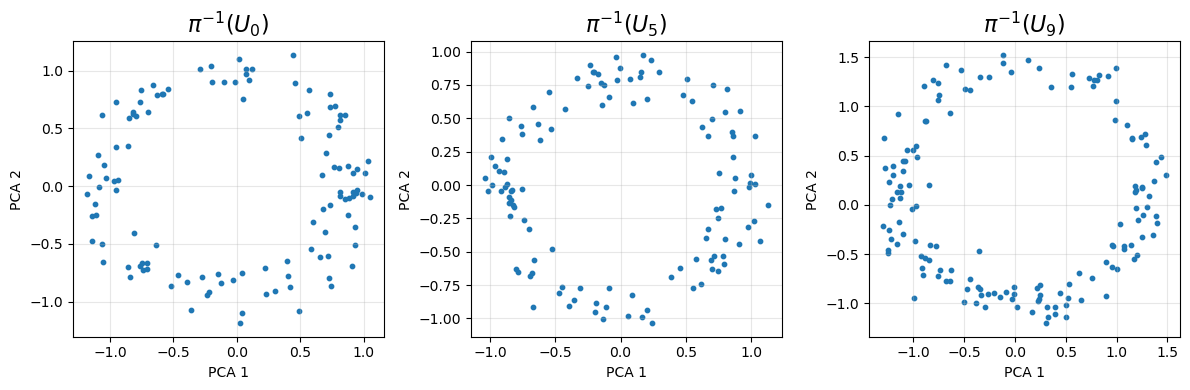

In [17]:
fig, axes = cb.get_local_pca(data, 
                      cover.U,
                      to_view = [0,5,9],
                     )
plt.show()

The projections suggest that each $\pi^{-1}(U_{j})$ is concentrated around a geometric circle, which supports the hypothesis that the data has the structure of a discrete approximate circle bundle over $\mathbb{S}^{1}$. Up to isomorphism, the only true circle bundles over $\mathbb{S}^{1}$ are the torus (trivial) and the Klein bottle (non-orientable). These two possibilities are distinguished by the orientation class $w_{1}$ (the Euler class is trivial for any circle bundle over $\mathbb{S}^{1}$).

Construct a bundle object. Compute local trivializations (using $\text{PCA}_{2}$ by default) and approximate transition matrices:

<IPython.core.display.Math object>

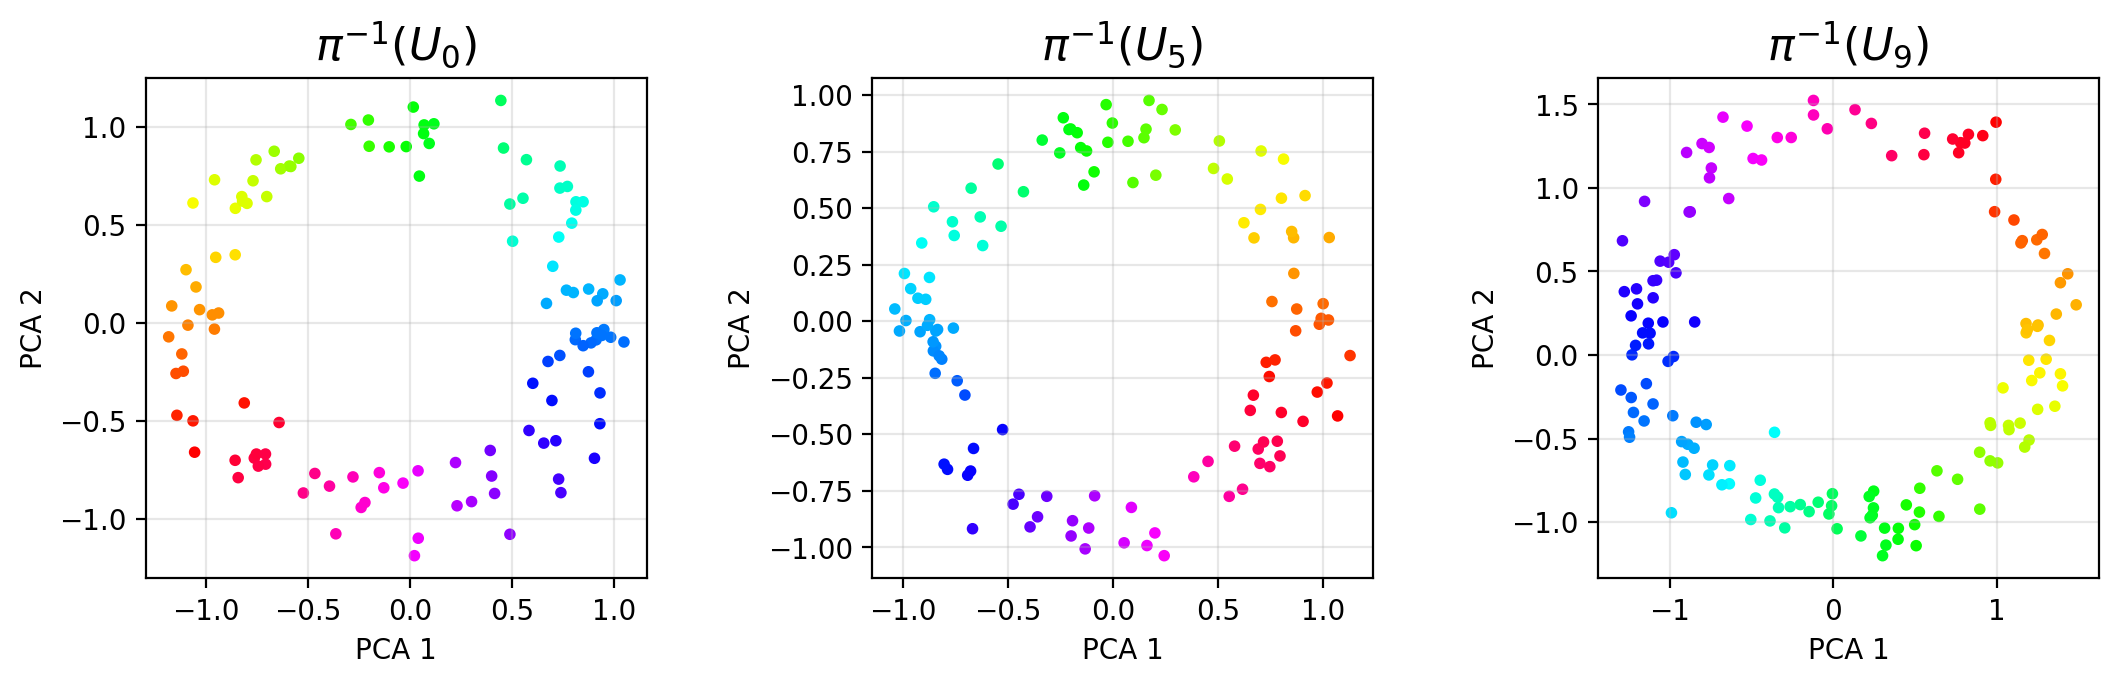

In [7]:
bundle = cb.Bundle(X = data, U = cover.U)
local_triv_result = bundle.get_local_trivs(show_summary = True)

#Show PCA projections colored according to local circular coordinate
fig, axes = cb.get_local_pca(
    data, 
    cover.U,
    to_view = [0,5,9],
    f = local_triv_result.f,
    )
plt.show()

Observe that local circular coordinate systems are not synchronized in the sense that neither the phases nor the orientations are aligned; the change-of-coordinates map on each set $\pi^{-1}(U_{j}\cap U_{k})$ is modeled by the corresponding approximate transition matrix $\Omega_{jk}$. Together, these matrices can be interpreted as a discrete approximate cocycle which encodes the global topological structure (see theory section for details). 

Now, compute characteristic class information:

In [8]:
class_result = bundle.get_classes(show_classes = True)


<IPython.core.display.Math object>

The characteristic classes indicate that the global structure is trivial (as expected), so a global coordinate system is possible. Synchronize local circular coordinates and compute a global toroidal coordinate system:

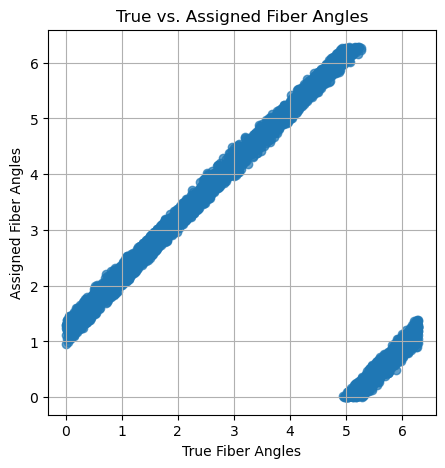

In [9]:
fiber_angles = bundle.get_global_trivialization(pou = cover.pou)

#Show the correlation between true and assigned fiber coordinates
plt.figure(figsize=(5,5))
plt.scatter(true_fiber_angles, fiber_angles, alpha=0.7)
plt.xlabel("True Fiber Angles")
plt.ylabel("Assigned Fiber Angles")
plt.title("True vs. Assigned Fiber Angles")
plt.grid(True)
plt.show()

Note that the correlation is nearly perfect -- the true and assigned fiber coordinates roughly differ by a global isometry of $\mathbb{S}^{1}$.

Finally, get visualizations of the dataset colored according to assigned base and fiber coordinates:

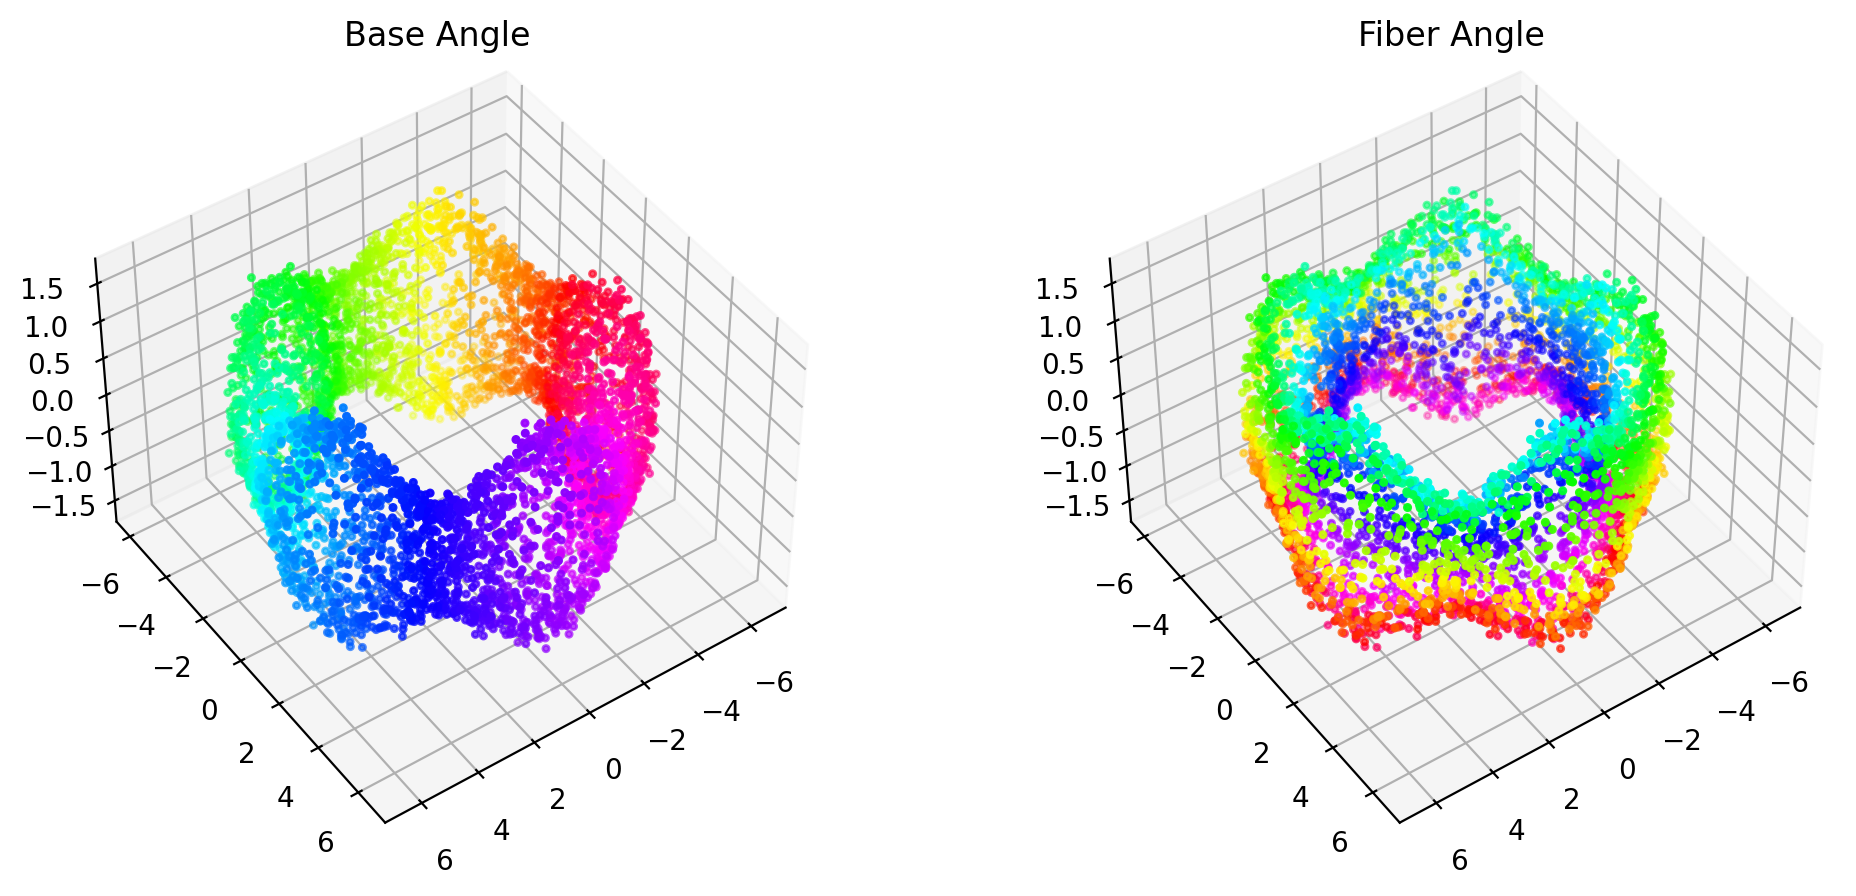

In [14]:
fig = plt.figure(figsize=(12, 5), dpi=200)

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
sc1 = ax1.scatter(
    data[:, 0], data[:, 1], data[:, 2],
    c=np.mod(base_angles, 2 * np.pi),
    cmap="hsv",
    norm=norm,
    s=5,
)
ax1.view_init(45, 55)
ax1.set_title("Base Angle")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
sc2 = ax2.scatter(
    data[:, 0], data[:, 1], data[:, 2],
    c=np.mod(fiber_angles, 2 * np.pi),
    cmap="hsv",
    norm=norm,
    s=5,
)
ax2.view_init(45, 55)
ax2.set_title("Fiber Angle")

plt.show()